# Demand Forecaster

## 1) Business problem

URL Project: [Sales Prediction for Big Mart Outlets](https://www.kaggle.com/datasets/shivan118/big-mart-sales-prediction-datasets?select=test.csv)

The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and predict the sales of each product at a particular outlet.

Using this model, BigMart will try to understand the properties of products and outlets which play a key role in increasing sales.

Please note that the data may have missing values as some stores might not report all the data due to technical glitches. Hence, it will be required to treat them accordingly.

**Data Dictionary**

We have a train (8523) and test (5681) data set, the train data set has both input and output variable(s). You need to predict the sales for the test data set.

#### Train file:
CSV containing the item outlet information with a sales value

**Variable Description**
* *Item_Identifier*: Unique product ID
* *Item_Weight*: Weight of product
* *Item_Fat_Content*: Whether the product is low fat or not
* *Item_Visibility*: The % of the total display area of all products in a store allocated to the particular product
* *Item_Type*: The category to which the product belongs
* *Item_MRP*: Maximum Retail Price (list price) of the product
* *Outlet_Identifier*: Unique store ID
* *Outlet_Establishment_Year*: The year in which the store was established
* *Outlet_Size*: The size of the store in terms of ground area covered
* *Outlet_Location_Type*: The type of city in which the store is located
* *Outlet_Type*: Whether the outlet is just a grocery store or some sort of supermarket
* *Item_Outlet_Sales*: sales of the product in t particular store. This is the outcome variable to be predicted.

### Test file:
CSV containing item outlet combinations for which sales need to be forecasted

**Variable Description**
* *Item_Identifier*:  Unique product ID
* *Item_Weight*: Weight of product
* *Item_Fat_Content*:  Whether the product is low fat or not
* *Item_Visibility*: The % of the total display area of all products in a store allocated to the particular product
* *Item_Type*: The category to which the product belongs
* *Item_MRP*:  Maximum Retail Price (list price) of the product
* *Outlet_Identifier*:  Unique store ID
* *Outlet_Establishment_Year*:  The year in which store store was established
* *Outlet_Size*:  The size of the store in terms of ground area covered
* *Outlet_Location_Type*: The type of city in which the store is located
* *Outlet_Type*: whether the outlet is just a grocery store or some sort of supermarket

### Submission file format
**Variable Description**
* *Item_Identifier*:  Unique product ID
* *Outlet_Identifier*:  Unique store ID
* *Item_Outlet_Sales*:  Sales of the product in t particular store. This is the outcome variable to be predicted.

**Evaluation Metric**

Your model performance will be evaluated on the basis of your prediction of the sales for the test data (test.csv), which contains similar data-points as train except for the sales to be predicted. Your submission needs to be in the format as shown in the same sample submission.

We at our end, have the actual sales for the test dataset, against which your predictions will be evaluated. We will use the Root Mean Square Error value to judge your response.

### 1.1) Imports and Load Data

In [1]:
import pandas as pd
import numpy as np

from scipy.stats import normaltest, zscore
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import missingno

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
sns.set_style("darkgrid", {"axes.facecolor": ".95"})
sns.set_context("paper")

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

### 1.2) Utilities Functions

In [3]:
def currencyFormatting(value):
    if value / 1000000 > 1:
        return f'$ {str(round(value/1000000, 2))}M'
    elif value / 100000 > 1:
        return f'$ {str(round(value/100000, 2))}KK'
    elif value / 1000 > 1:
        return f'$ {str(round(value/10000, 2))}k'
    else: 
        return f'$ {str(round(value, 2))}'

In [4]:
def resumeNumber(value):
    if value / 1000000 > 1:
        return f'{str(round(value/1000000, 2))}M'
    elif value / 100000 > 1:
        return f'{str(round(value/100000, 2))}KK'
    elif value / 1000 > 1:
        return f'{str(round(value/10000, 2))}k'
    else: 
        return f'{str(round(value, 2))}'

## 2) EDA - Exploratory Data Analysis

In [5]:
df_train_raw = pd.read_csv('../data/train.csv')
df_valid_raw = pd.read_csv('../data/test.csv')

In [6]:
display(df_train_raw.shape)
display(df_train_raw.head())

(8523, 12)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [7]:
display(df_valid_raw.shape)
display(df_valid_raw.head())

(5681, 11)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


In [8]:
df_train_raw.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [9]:
df_valid_raw.isnull().sum()

Item_Identifier                 0
Item_Weight                   976
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1606
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

In [10]:
df_train_raw.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [11]:
df_train_raw.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


# 3) Divisão dos dados em Treino e Teste

In [12]:
features_columns = [
    'Item_Identifier', 
    'Item_Weight', 
    'Item_Fat_Content', 
    'Item_Visibility',
    'Item_Type', 
    'Item_MRP', 
    'Outlet_Identifier',
    'Outlet_Establishment_Year', 
    'Outlet_Size', 
    'Outlet_Location_Type',
    'Outlet_Type'
]

target_column = ['Item_Outlet_Sales']

In [13]:
x_train, x_test, y_train, y_test = train_test_split(df_train_raw[features_columns], df_train_raw[target_column])

In [14]:
x_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [15]:
display(x_train.head(3))
display(x_test.head(3))

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDR36,6.715,Regular,0.121833,Baking Goods,43.5454,OUT045,2002,NaN,Tier 2,Supermarket Type1
1,FDC56,7.720,Low Fat,0.121498,Fruits and Vegetables,119.7440,OUT035,2004,Small,Tier 2,Supermarket Type1
2,FDK24,9.195,Low Fat,0.101500,Baking Goods,45.2744,OUT045,2002,NaN,Tier 2,Supermarket Type1


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDD58,7.76,Low Fat,0.059341,Snack Foods,99.7700,OUT035,2004,Small,Tier 2,Supermarket Type1
1,FDM58,16.85,Regular,0.133385,Snack Foods,109.8544,OUT010,1998,NaN,Tier 3,Grocery Store
2,NCE30,16.00,Low Fat,0.099054,Household,212.6902,OUT013,1987,High,Tier 3,Supermarket Type1


In [16]:
display(y_train.head(3))
display(y_test.head(3))

,Item_Outlet_Sales
0,838.908
1,3355.632
2,679.116


,Item_Outlet_Sales
0,798.9600
1,223.7088
2,637.1706


# 4) Lidando com dados outliers

**Item_Identifier**

In [17]:
x_train['Item_Identifier'].value_counts()

Item_Identifier
FDG09    9
NCY18    9
FDG33    9
FDD29    8
DRI03    8
        ..
FDD17    1
FDA51    1
FDC23    1
NCL42    1
FDQ22    1
Name: count, Length: 1550, dtype: int64

Essa variável não tem muito o que fazer, embora itens que aparecem apenas uma vez podem ser uma pedra no sapato.

**Item_Weight**

<Axes: xlabel='Item_Weight'>

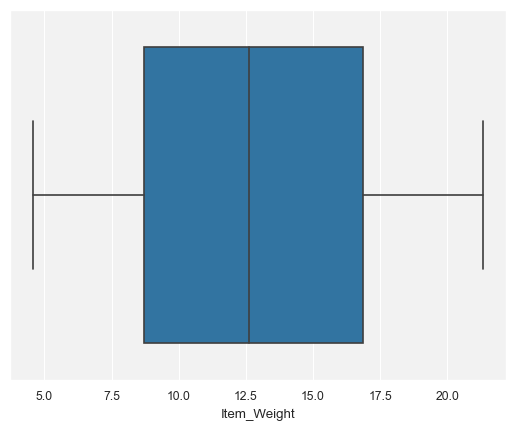

In [18]:
sns.boxplot(x=x_train['Item_Weight'])

**Item_Visibility**

<Axes: xlabel='Item_Visibility'>

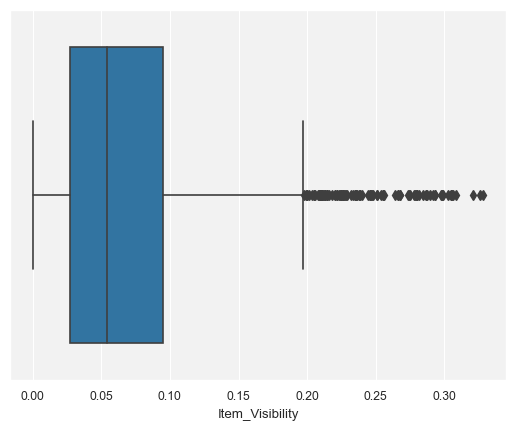

In [19]:
sns.boxplot(x=x_train['Item_Visibility'])

Esse atributo possui vários outliers. Mas como foi analisado no projeto de análise de dados, não necessariamente os outliers significam erros. Aqui são itens que possuem alta visibilidade nas prateleiras das lojas.

**Item_MRP**

<Axes: xlabel='Item_MRP'>

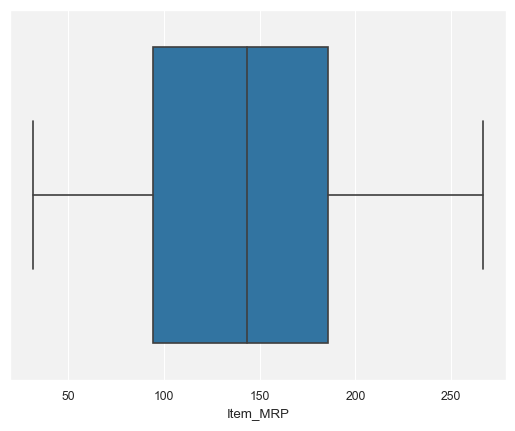

In [20]:
sns.boxplot(x=x_train['Item_MRP'])

**Item_Fat_Content**

In [21]:
x_train['Item_Fat_Content'].value_counts()

Item_Fat_Content
Low Fat    3792
Regular    2191
LF          236
reg          87
low fat      86
Name: count, dtype: int64

Temos que lidar com esses itens aqui.

**Item_Type**

In [22]:
x_train['Item_Type'].value_counts()

Item_Type
Fruits and Vegetables    927
Snack Foods              899
Household                693
Frozen Foods             624
Dairy                    521
Canned                   491
Baking Goods             487
Health and Hygiene       371
Soft Drinks              331
Meat                     322
Breads                   190
Hard Drinks              172
Others                   117
Starchy Foods            111
Breakfast                 87
Seafood                   49
Name: count, dtype: int64

Pode-se dizer que está desbalanceado, mas a quantidade de registros pode ser suficiente para o modelo conseguir aprender.

**Outlet_Identifier**

In [23]:
x_train['Outlet_Identifier'].value_counts()

Outlet_Identifier
OUT035    709
OUT049    702
OUT027    700
OUT018    700
OUT046    698
OUT013    695
OUT045    693
OUT017    687
OUT019    406
OUT010    402
Name: count, dtype: int64

Está ok.

**Outlet_Establishment_Year**

In [24]:
x_train['Outlet_Establishment_Year'].value_counts()

Outlet_Establishment_Year
1985    1106
2004     709
1999     702
2009     700
1997     698
1987     695
2002     693
2007     687
1998     402
Name: count, dtype: int64

Está ok, embora eu acredite que essa variável seja irrelevante para o modelo.

**Outlet_Size**

In [25]:
x_train['Outlet_Size'].value_counts()

Outlet_Size
Medium    2102
Small     1813
High       695
Name: count, dtype: int64

Está ok.

**Outlet_Location_Type**

In [26]:
x_train['Outlet_Location_Type'].value_counts()

Outlet_Location_Type
Tier 3    2497
Tier 2    2089
Tier 1    1806
Name: count, dtype: int64

Está ok.

**Outlet_Type**

In [27]:
x_train['Outlet_Type'].value_counts()

Outlet_Type
Supermarket Type1    4184
Grocery Store         808
Supermarket Type3     700
Supermarket Type2     700
Name: count, dtype: int64

Está ok.

# 5) Tratamento de valores ausentes

In [28]:
display(x_train.shape)
x_train.isnull().sum()

(6392, 11)

Item_Identifier                 0
Item_Weight                  1106
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1782
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

**Item Weight**

In [29]:
x_train['Item_Weight'].fillna(x_train.groupby('Item_Type')['Item_Weight'].transform('mean'), inplace=True)
x_test['Item_Weight'].fillna(x_test.groupby('Item_Type')['Item_Weight'].transform('mean'), inplace=True)

Eu decidi utilizar o valor médio do Item weight agrupado por Item Type porque:
1. O atributo está bem distribuído, então não há diferença em usar a média ou a mediana (Talvez haja para departamentos).
2. O Item_Type é o atributo que possui maior correlação com o Item_Weight

**Outlet Size**

In [30]:
x_train['Outlet_Size'].fillna('-1', inplace=True)
x_test['Outlet_Size'].fillna('-1', inplace=True)

<Axes: >

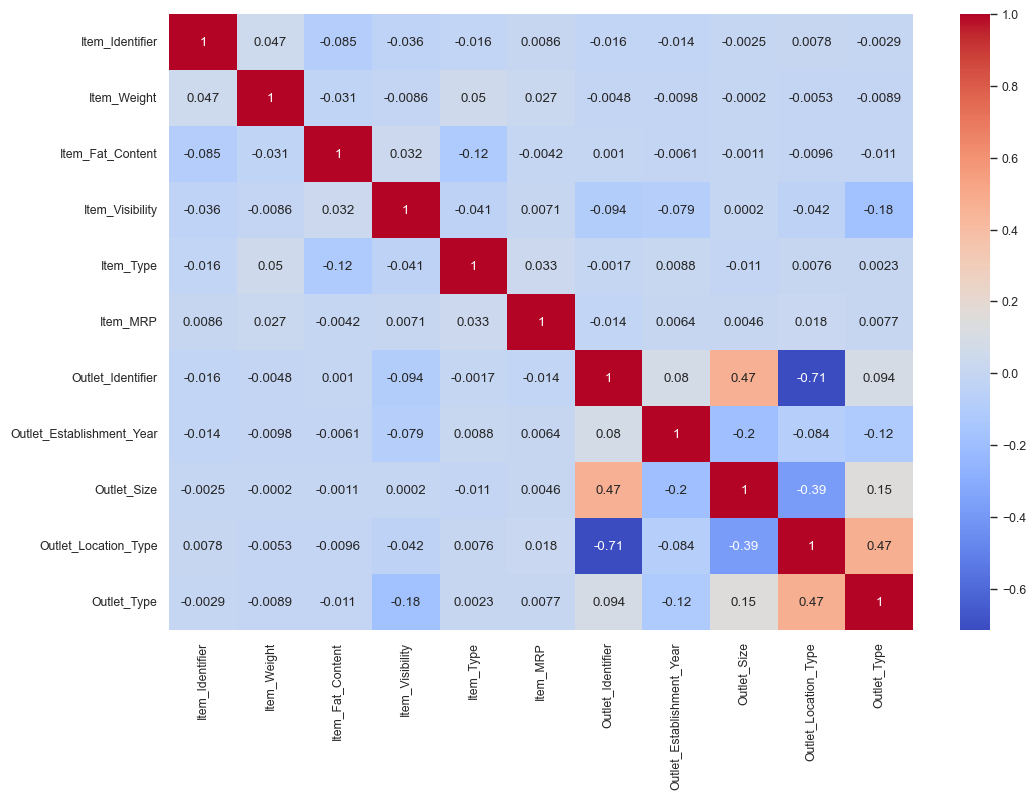

In [31]:
df_corr = x_train.copy()

le = LabelEncoder()
df_corr['Item_Identifier'] = le.fit_transform(df_corr['Item_Identifier'])
df_corr['Item_Fat_Content'] = le.fit_transform(df_corr['Item_Fat_Content'])
df_corr['Item_Type'] = le.fit_transform(df_corr['Item_Type'])
df_corr['Outlet_Identifier'] = le.fit_transform(df_corr['Outlet_Identifier'])
df_corr['Outlet_Size'] = le.fit_transform(df_corr['Outlet_Size'])
df_corr['Outlet_Location_Type'] = le.fit_transform(df_corr['Outlet_Location_Type'])
df_corr['Outlet_Type'] = le.fit_transform(df_corr['Outlet_Type'])

plt.figure(figsize=(12, 8))
sns.heatmap(df_corr.corr(), annot=True, cmap='coolwarm')

In [32]:
x_train.groupby(['Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'], as_index=False)['Item_Identifier'].count()

,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Identifier
0,-1,Tier 2,Supermarket Type1,1380
1,-1,Tier 3,Grocery Store,402
2,High,Tier 3,Supermarket Type1,695
3,Medium,Tier 1,Supermarket Type1,702
4,Medium,Tier 3,Supermarket Type2,700
5,Medium,Tier 3,Supermarket Type3,700
6,Small,Tier 1,Grocery Store,406
7,Small,Tier 1,Supermarket Type1,698
8,Small,Tier 2,Supermarket Type1,709


In [33]:
x_test.groupby(['Outlet_Size', 'Outlet_Location_Type'], as_index=False)['Item_Identifier'].count()

,Outlet_Size,Outlet_Location_Type,Item_Identifier
0,-1,Tier 2,475
1,-1,Tier 3,153
2,High,Tier 3,237
3,Medium,Tier 1,228
4,Medium,Tier 3,463
5,Small,Tier 1,354
6,Small,Tier 2,221


In [34]:
def fillna_outlet_size(row):
    if row.Outlet_Size == '-1':
        if row.Outlet_Location_Type == 'Tier 2':
            return 'Small'
        elif row.Outlet_Location_Type == 'Tier 3':
            return 'Medium' # Mas eu posso remover talvez.
    else: 
        return row.Outlet_Size 


In [35]:
x_train['Outlet_Size'] = x_train.apply(lambda row: fillna_outlet_size(row), axis=1)
x_test['Outlet_Size'] = x_test.apply(lambda row: fillna_outlet_size(row), axis=1)

Justificativa:
* Onde eu preenchi os valores ausentes como `Small`, foram em lojas cujo Location Type eram Tier 2, porque em todas as lojas Tier 2 eram Small;
* Onde eu preenchi os valores ausentes como `Medium`, foi igual ao valor majoritário do atributo Outlet Size cujo os Location Type eram iguais a `Tier 3`. Pode ser que essa relação não faça muito sentido e que eu tenha que mudar futuramente.

**Item_Fat_Content**

In [36]:
x_train['Item_Fat_Content'].value_counts()

Item_Fat_Content
Low Fat    3792
Regular    2191
LF          236
reg          87
low fat      86
Name: count, dtype: int64

In [37]:
map_fat_content = {
    'Low Fat': 'Low Fat',
    'Regular': 'Regular',
    'LF': 'Low Fat',
    'reg': 'Regular',
    'low fat': 'Low Fat'
}

x_train['Item_Fat_Content'] = x_train['Item_Fat_Content'].map(map_fat_content)
x_test['Item_Fat_Content'] = x_test['Item_Fat_Content'].map(map_fat_content)

Justificativa: Como foi analisado no projeto de análise de dados, esses valores claramente se tratam de divergências no cadastro manual para o mesmo tipo de categoria. Portant, usando o pensamento lógico, percebemos que há apenas dois tipos de valores: `Low Fat` e `Regular`.

**Results**

In [38]:
display(x_train.isnull().sum())
display(x_test.isnull().sum())

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
dtype: int64

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
dtype: int64

# 6) Transformação dos atributos

* `Item_Identifier`: Ordinal Encoder ou Label Encoder
* `Item_Weight`: Padronização ou Normalização dos dados
* `Item_Fat_Content`: Label Encoder
* `Item_Visibility`: Padronização ou Normalização dos dados
* `Item_Type`: Ordinal Encoder ou One Hot Encoder
* `Item_MRP`: Padronização ou Normalização dos dados 
* `Outlet_Identifier`: Ordinal Encoder ou Label Encoder
* `Outlet_Establishment_Year`: Desconsiderar
* `Outlet_Size`: Ordinal Encoder (Testar One Hot Encoder)
* `Outlet_Location_Type`: Ordinal Encoder (Testar One Hot Encoder)
* `Outlet_Type`: Ordinal Encoder (Testar One Hot Encoder)

In [89]:
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder

In [90]:
x_train_transformed = x_train.copy()
x_test_transformed = x_test.copy()

**Item_Fat_Content, Outlet_Size, Outlet_Location_Type, Outlet_Type**

In [91]:
map_fat_content_encode = {
    'Regular': 0,
    'Low Fat': 1
}

map_outlet_size_encode = {
    'Small': 0, 
    'Medium': 0.5, 
    'High': 1
}

map_location_type_encode = {
    'Tier 1': 0, 
    'Tier 2': 0.5, 
    'Tier 3': 1
}

map_outlet_type_encode = {
'Grocery Store': 0, 
'Supermarket Type1': 0.33, 
'Supermarket Type2': 0.66,
'Supermarket Type3': 1, 
}

In [92]:
x_train_transformed['Item_Fat_Content'] = x_train_transformed['Item_Fat_Content'].map(map_fat_content_encode)
x_train_transformed['Outlet_Size'] = x_train_transformed['Outlet_Size'].map(map_outlet_size_encode)
x_train_transformed['Outlet_Location_Type'] = x_train_transformed['Outlet_Location_Type'].map(map_location_type_encode)
x_train_transformed['Outlet_Type'] = x_train_transformed['Outlet_Type'].map(map_outlet_type_encode)

x_test_transformed['Item_Fat_Content'] = x_test_transformed['Item_Fat_Content'].map(map_fat_content_encode)
x_test_transformed['Outlet_Size'] = x_test_transformed['Outlet_Size'].map(map_outlet_size_encode)
x_test_transformed['Outlet_Location_Type'] = x_test_transformed['Outlet_Location_Type'].map(map_location_type_encode)
x_test_transformed['Outlet_Type'] = x_test_transformed['Outlet_Type'].map(map_outlet_type_encode)

In [93]:
display(x_test_transformed['Item_Fat_Content'].value_counts())
display(x_test_transformed['Outlet_Size'].value_counts())
display(x_test_transformed['Outlet_Location_Type'].value_counts())
display(x_test_transformed['Outlet_Type'].value_counts())

Item_Fat_Content
1    1403
0     728
Name: count, dtype: int64

Outlet_Size
0.0    1050
0.5     844
1.0     237
Name: count, dtype: int64

Outlet_Location_Type
1.0    853
0.5    696
0.0    582
Name: count, dtype: int64

Outlet_Type
0.33    1393
0.00     275
1.00     235
0.66     228
Name: count, dtype: int64

In [95]:
x_test_transformed.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDD58,7.76,1,0.059341,Snack Foods,99.7700,OUT035,2004,0.0,0.5,0.33
1,FDM58,16.85,0,0.133385,Snack Foods,109.8544,OUT010,1998,0.5,1.0,0.00
2,NCE30,16.00,1,0.099054,Household,212.6902,OUT013,1987,1.0,1.0,0.33
3,NCC07,19.60,1,0.023951,Household,105.6964,OUT046,1997,0.0,0.0,0.33
4,DRF36,16.10,1,0.023673,Soft Drinks,189.0846,OUT018,2009,0.5,1.0,0.66


**Outlet Identifier Ordinal**

In [102]:
ordinal_encoder = LabelEncoder()

features_encoded = ordinal_encoder.fit_transform(x_train_transformed['Outlet_Identifier'])
x_train_transformed['Outlet_Identifier_ordinal'] = features_encoded

features_encoded = ordinal_encoder.transform(x_test_transformed['Outlet_Identifier'])
x_test_transformed['Outlet_Identifier_ordinal'] = features_encoded

**Item Type**

In [103]:
ohe = OneHotEncoder(sparse=False)

Item_Type_ohe_train = ohe.fit_transform(x_train_transformed[['Item_Type']])
Item_Type_ohe_test = ohe.transform(x_test_transformed[['Item_Type']])

# columns_ohe = ['Item_Type_{}'.format(str.replace(item ,' ', '_')) for item in list(ohe.categories_[0])]
columns_ohe_train = pd.DataFrame(Item_Type_ohe_train, columns=ohe.get_feature_names_out(['Item_Type']))
columns_ohe_test = pd.DataFrame(Item_Type_ohe_test, columns=ohe.get_feature_names_out(['Item_Type']))

for row in ohe.get_feature_names_out(['Item_Type']):
    x_train_transformed[row.replace(' ', '_')] = columns_ohe_train[row]
    x_test_transformed[row.replace(' ', '_')] = columns_ohe_test[row]

In [104]:
x_train_transformed.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Identifier_ordinal,Outlet_Identifier_ordinal,Item_Type_Baking_Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen_Foods,Item_Type_Fruits_and_Vegetables,Item_Type_Hard_Drinks,Item_Type_Health_and_Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack_Foods,Item_Type_Soft_Drinks,Item_Type_Starchy_Foods
0,FDR36,6.715000,0,0.121833,Baking Goods,43.5454,OUT045,2002,0.0,0.5,0.33,7,7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,FDC56,7.720000,1,0.121498,Fruits and Vegetables,119.7440,OUT035,2004,0.0,0.5,0.33,6,6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,FDK24,9.195000,1,0.101500,Baking Goods,45.2744,OUT045,2002,0.0,0.5,0.33,7,7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,FDG56,13.247303,0,0.071107,Fruits and Vegetables,60.5536,OUT027,1985,0.5,1.0,1.00,5,5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,DRG11,6.385000,1,0.083769,Hard Drinks,109.8596,OUT013,1987,1.0,1.0,0.33,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [105]:
x_test_transformed.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Identifier_ordinal,Outlet_Identifier_ordinal,Item_Type_Baking_Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen_Foods,Item_Type_Fruits_and_Vegetables,Item_Type_Hard_Drinks,Item_Type_Health_and_Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack_Foods,Item_Type_Soft_Drinks,Item_Type_Starchy_Foods
0,FDD58,7.76,1,0.059341,Snack Foods,99.7700,OUT035,2004,0.0,0.5,0.33,6,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,FDM58,16.85,0,0.133385,Snack Foods,109.8544,OUT010,1998,0.5,1.0,0.00,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,NCE30,16.00,1,0.099054,Household,212.6902,OUT013,1987,1.0,1.0,0.33,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NCC07,19.60,1,0.023951,Household,105.6964,OUT046,1997,0.0,0.0,0.33,8,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,DRF36,16.10,1,0.023673,Soft Drinks,189.0846,OUT018,2009,0.5,1.0,0.66,3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# 7) Seleção de atributos

In [109]:
features_columns = [
    # 'Item_Identifier', # Somente em modelos de árvore
    # 'Outlet_Identifier',
    # 'Outlet_Establishment_Year',
    # 'Item_Type',
    'Outlet_Identifier_ordinal',
    'Item_Weight',
    'Item_Fat_Content',
    'Item_Visibility',
    'Item_MRP',
    'Outlet_Size',
    'Outlet_Location_Type',
    'Outlet_Type',
    'Item_Type_Baking_Goods',
    'Item_Type_Breads',
    'Item_Type_Breakfast',
    'Item_Type_Canned',
    'Item_Type_Dairy',
    'Item_Type_Frozen_Foods',
    'Item_Type_Fruits_and_Vegetables',
    'Item_Type_Hard_Drinks',
    'Item_Type_Health_and_Hygiene',
    'Item_Type_Household',
    'Item_Type_Meat',
    'Item_Type_Others',
    'Item_Type_Seafood',
    'Item_Type_Snack_Foods',
    'Item_Type_Soft_Drinks',
    'Item_Type_Starchy_Foods'
]

In [110]:
x_train_transformed = x_train_transformed[features_columns]
x_test_transformed = x_test_transformed[features_columns]

In [111]:
display(x_train_transformed.head())
display(x_test_transformed.head())

,Outlet_Identifier_ordinal,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Type_Baking_Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen_Foods,Item_Type_Fruits_and_Vegetables,Item_Type_Hard_Drinks,Item_Type_Health_and_Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack_Foods,Item_Type_Soft_Drinks,Item_Type_Starchy_Foods
0,7,6.715000,0,0.121833,43.5454,0.0,0.5,0.33,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6,7.720000,1,0.121498,119.7440,0.0,0.5,0.33,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7,9.195000,1,0.101500,45.2744,0.0,0.5,0.33,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5,13.247303,0,0.071107,60.5536,0.5,1.0,1.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,6.385000,1,0.083769,109.8596,1.0,1.0,0.33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,Outlet_Identifier_ordinal,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Type_Baking_Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen_Foods,Item_Type_Fruits_and_Vegetables,Item_Type_Hard_Drinks,Item_Type_Health_and_Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack_Foods,Item_Type_Soft_Drinks,Item_Type_Starchy_Foods
0,6,7.76,1,0.059341,99.7700,0.0,0.5,0.33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0,16.85,0,0.133385,109.8544,0.5,1.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1,16.00,1,0.099054,212.6902,1.0,1.0,0.33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8,19.60,1,0.023951,105.6964,0.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3,16.10,1,0.023673,189.0846,0.5,1.0,0.66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## 8) Padronização dos Dados

In [112]:
x_train_transformed

,Outlet_Identifier_ordinal,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Type_Baking_Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen_Foods,Item_Type_Fruits_and_Vegetables,Item_Type_Hard_Drinks,Item_Type_Health_and_Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack_Foods,Item_Type_Soft_Drinks,Item_Type_Starchy_Foods
0,7,6.715000,0,0.121833,43.5454,0.0,0.5,0.33,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6,7.720000,1,0.121498,119.7440,0.0,0.5,0.33,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7,9.195000,1,0.101500,45.2744,0.0,0.5,0.33,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5,13.247303,0,0.071107,60.5536,0.5,1.0,1.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,6.385000,1,0.083769,109.8596,1.0,1.0,0.33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6387,1,6.590000,1,0.105509,85.6908,1.0,1.0,0.33,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6388,9,12.100000,1,0.030174,76.6670,0.5,0.0,0.33,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6389,7,20.250000,1,0.059055,247.3460,0.0,0.5,0.33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6390,8,5.465000,0,0.000000,129.1626,0.0,0.0,0.33,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [113]:
from sklearn.preprocessing import StandardScaler

In [115]:
standard_scaler = StandardScaler()

x_train_scaled = standard_scaler.fit_transform(x_train_transformed)
x_test_scaled = standard_scaler.transform(x_test_transformed)

## 11) Primeira modelagem

**Decision Tree**

In [119]:
from sklearn.tree import DecisionTreeRegressor

In [144]:
X = x_train_scaled
y = y_train

tree_reg = DecisionTreeRegressor(max_depth=2)
tree_reg.fit(X, y)

predicted_train = tree_reg.predict(X)
predicted_test = tree_reg.predict(x_test_scaled)

x_train_transformed['Outlet_Sales'] = y_train
x_test_transformed['Outlet_Sales'] = y_test

x_train_transformed['Predicted'] = predicted_train
x_test_transformed['Predicted'] = predicted_test

In [145]:
tree_reg.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.62089917,
       0.        , 0.        , 0.37910083, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

## 12) Testar diferentes modelos

## 13) Ajustar Hiperparâmetros